# Linear Regression Using Tensors and Autograd

## Dataset fetch and train test split

In [18]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing_df = housing.frame

In [19]:
housing_df = housing.frame
print(housing_df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [20]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [21]:
X, y = housing_df.drop(columns=["MedHouseVal"]), housing_df["MedHouseVal"]
print(X.shape, y.shape)

(20640, 8) (20640,)


In [22]:
from sklearn.model_selection import train_test_split

# 1. First split: Separate out the Test set (20% of total)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Second split: Split the remaining 80% into Train and Valid
# 0.25 of 0.80 = 0.20 of the original total.
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (12384, 8), (12384,)
Valid: (4128, 8), (4128,)
Test:  (4128, 8), (4128,)


### Scaling

In [23]:
import torch

In [24]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
means = torch.tensor(X_train.mean(dim=0, keepdim=True), dtype=torch.float32) # compute means of each column
stds = torch.tensor(X_train.std(dim=0, keepdim=True), dtype=torch.float32) # compute stds of each column
X_train = (X_train - means) / stds
X_valid = (X_valid - means) / stds
X_test = (X_test - means) / stds

C:\Users\kiran\AppData\Local\Temp\ipykernel_22012\911013326.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = torch.tensor(X_train.mean(dim=0, keepdim=True), dtype=torch.float32) # compute means of each column
C:\Users\kiran\AppData\Local\Temp\ipykernel_22012\911013326.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds = torch.tensor(X_train.std(dim=0, keepdim=True), dtype=torch.float32) # compute stds of each column


In [25]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: torch.Size([12384, 8]), (12384,)
Valid: torch.Size([4128, 8]), (4128,)
Test:  torch.Size([4128, 8]), (4128,)


### Convert test numpy array as tensor with adding second dimension 

In [26]:
y_train = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_valid = torch.FloatTensor(y_valid.values).reshape(-1, 1)
y_test = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [27]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: torch.Size([12384, 8]), torch.Size([12384, 1])
Valid: torch.Size([4128, 8]), torch.Size([4128, 1])
Test:  torch.Size([4128, 8]), torch.Size([4128, 1])


## Implementation

## creating a linear equation

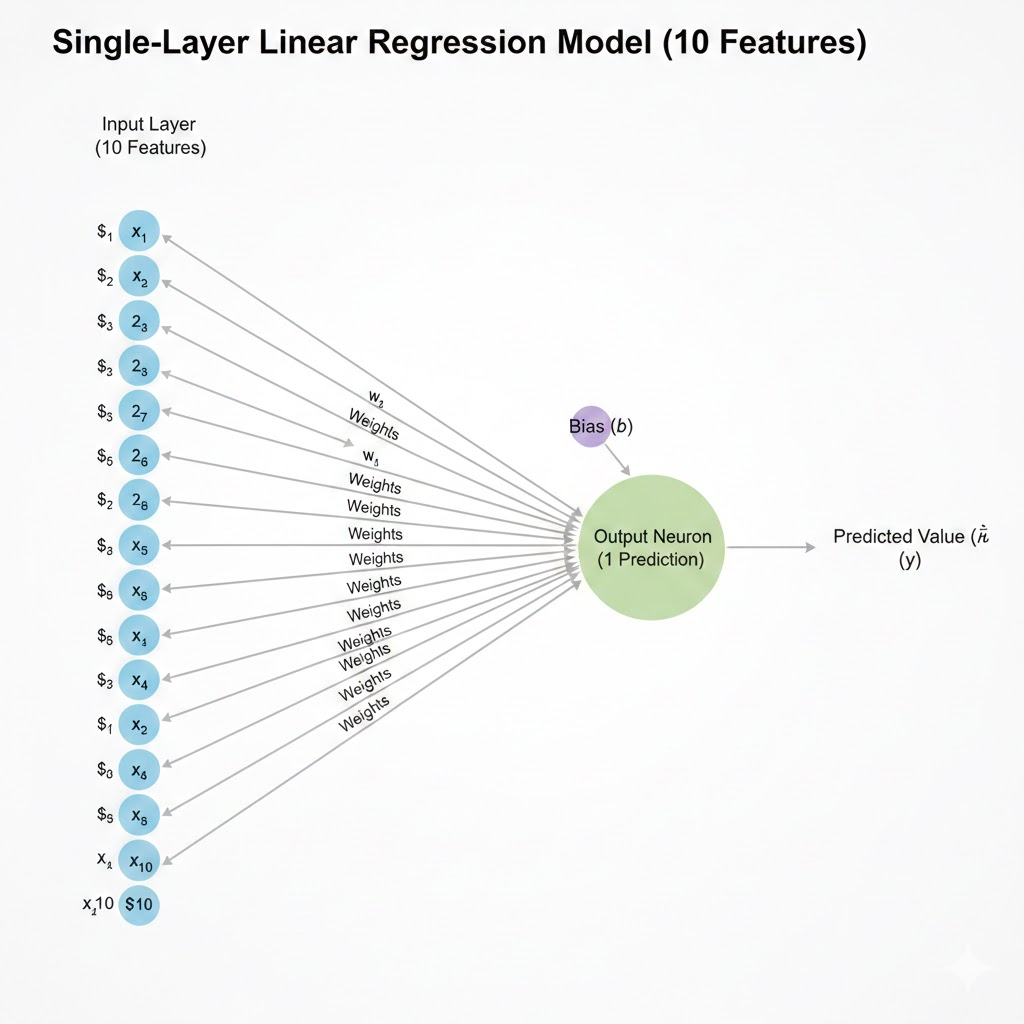

In [28]:
torch.manual_seed(42)
input_size = X_train.shape[1]
W = torch.randn(input_size, 1, requires_grad=True, dtype=torch.float32)
b = torch.randn((), requires_grad=True, dtype=torch.float32)

In [29]:
W, b

(tensor([[ 0.3367],
         [ 0.1288],
         [ 0.2345],
         [ 0.2303],
         [-1.1229],
         [-0.1863],
         [ 2.2082],
         [-0.6380]], requires_grad=True),
 tensor(0.4617, requires_grad=True))

### Model Building

In [30]:
learning_rate = 0.01
n_epochs = 1000
for epoch in range(n_epochs):
    y_pred = X_train @ W + b
    # print(y_pred)
    loss = torch.mean((y_pred-y_train)**2)
    print(f"Epoch {epoch}: loss: {loss.item()}")
    loss.backward()
    

    with torch.no_grad():
        print(  f" Epoch {epoch} b.grad: {b.grad}, W.grad: {W.grad}"  )
        b -= learning_rate * b.grad
        W -= learning_rate * W.grad
        b.grad.zero_()
        W.grad.zero_()
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}")

Epoch 0: loss: 14.309830665588379
 Epoch 0 b.grad: -3.212841033935547, W.grad: tensor([[-1.1114],
        [ 0.5908],
        [ 1.3769],
        [ 1.3520],
        [-2.8977],
        [-0.4710],
        [ 6.1933],
        [-5.5117]])
Epoch 1/1000, Loss: 14.309830665588379
Epoch 1: loss: 13.397154808044434
 Epoch 1 b.grad: -3.1485841274261475, W.grad: tensor([[-1.0889],
        [ 0.5560],
        [ 1.3161],
        [ 1.2919],
        [-2.8091],
        [-0.4564],
        [ 5.9546],
        [-5.2803]])
Epoch 2/1000, Loss: 13.397154808044434
Epoch 2: loss: 12.55055046081543
 Epoch 2 b.grad: -3.0856125354766846, W.grad: tensor([[-1.0667],
        [ 0.5225],
        [ 1.2580],
        [ 1.2343],
        [-2.7236],
        [-0.4422],
        [ 5.7255],
        [-5.0582]])
Epoch 3/1000, Loss: 12.55055046081543
Epoch 3: loss: 11.765054702758789
 Epoch 3 b.grad: -3.023900032043457, W.grad: tensor([[-1.0451],
        [ 0.4904],
        [ 1.2026],
        [ 1.1790],
        [-2.6410],
        [-0.4

In [31]:
X_new = X_test[:3]
with torch.no_grad():
    y_pred = X_new @ W + b
print("Predictions:", y_pred.numpy())

Predictions: [[0.87286735]
 [1.6506106 ]
 [2.692894  ]]


In [32]:
y_test[:3]

tensor([[0.4770],
        [0.4580],
        [5.0000]])

### With multiple Layers

In [36]:
W1 = torch.randn(input_size, 5, requires_grad=True, dtype=torch.float32)
b1 = torch.randn(5, requires_grad=True, dtype=torch.float32)

W2 = torch.randn(5, 1, requires_grad=True, dtype=torch.float32)
b2 = torch.randn((), requires_grad=True, dtype=torch.float32)

epochs = 200
learning_rate = 0.01
for epoch in range(epochs):
    h1 = X_train @ W1 + b1
    y_pred = h1 @ W2 + b2
    loss = torch.mean((y_pred-y_train)**2)
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        W -= learning_rate * W.grad
        b.grad.zero_()
        W.grad.zero_()
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}")

Epoch 1/1000, Loss: 215.7292938232422
Epoch 2/1000, Loss: 215.7292938232422
Epoch 3/1000, Loss: 215.7292938232422
Epoch 4/1000, Loss: 215.7292938232422
Epoch 5/1000, Loss: 215.7292938232422
Epoch 6/1000, Loss: 215.7292938232422
Epoch 7/1000, Loss: 215.7292938232422
Epoch 8/1000, Loss: 215.7292938232422
Epoch 9/1000, Loss: 215.7292938232422
Epoch 10/1000, Loss: 215.7292938232422
Epoch 11/1000, Loss: 215.7292938232422
Epoch 12/1000, Loss: 215.7292938232422
Epoch 13/1000, Loss: 215.7292938232422
Epoch 14/1000, Loss: 215.7292938232422
Epoch 15/1000, Loss: 215.7292938232422
Epoch 16/1000, Loss: 215.7292938232422
Epoch 17/1000, Loss: 215.7292938232422
Epoch 18/1000, Loss: 215.7292938232422
Epoch 19/1000, Loss: 215.7292938232422
Epoch 20/1000, Loss: 215.7292938232422
Epoch 21/1000, Loss: 215.7292938232422
Epoch 22/1000, Loss: 215.7292938232422
Epoch 23/1000, Loss: 215.7292938232422
Epoch 24/1000, Loss: 215.7292938232422
Epoch 25/1000, Loss: 215.7292938232422
Epoch 26/1000, Loss: 215.729293823